In [2097]:
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()


True

Carrier colors dictionary:

In [2098]:
carrier_color_dict = {
                        'Verizon': '#b00000',
                        'AT&T': '#067ab4',
                        'T-Mobile': '#e60076',
                        'Sprint': '#ffaa00',
                        'Dish': '#3F3F3F',
                        'EE': '#2e9b9d',
                        'O2': '#010066',
                        'Three': '#000000',
                        'Vodafone': '#f80000',
                        'O2 UK': '#010066',
                        'Three UK': '#000000',
                        'Vodafone UK': '#f80000',
                        'Sunrise': '#d0606f',
                        'Swisscom': '#5b92cc',
                        'Salt': '#56bf83',
                        'ODIDO': '#FF7621',
                        'KPN': '#FFBB00',
                        'Vodafone NL': '#f80000',
                        'KT': '#FF7621',
                        'SK Telecom': '#FFBB00',
                        'LG U+': '#f80000'
                     }

In [2099]:
carrier_color_dict_reporting = {
                                'Salt': '#1A1A1A',
                                'Sunrise': '#E6003C',
                                'Swisscom': '#001155',
                                'AT&T': '#008FCC',
                                'Sprint': '#FFAA00',
                                'T-Mobile': '#E60076',
                                'Verizon': '#B00000',
                                'EE': '#1D9F9E',
                                'O2': '#010066',
                                'Three': '#070707',
                                'Vodafone': '#F80000',
                                'KT': '#FF3333',
                                'LG U+': '#CC0066',
                                'SK Telecom': '#FF9933',
                                'Dish': '#F87217'
                            }

Network type colors dictionary:

In [2100]:
dl_color_dict = {
  '5G': '#009697', 
  'Mixed-5G': '#3CB371', 
  'LTE': '#58595b',
  'Non-LTE': '#f4a460'
}

Metadata test summary by CSDI

In [2101]:
curr_csid = 12705

In [2102]:
ts_curr = f'''
SELECT
   date_trunc('seconds',ts.start_time)::timestamp without time zone as start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name AS carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ',') AS best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name AS report_set_collector,
   (ts.start_time AT TIME ZONE 'utc' AT TIME ZONE ca.time_zone) AS local_time
FROM prod_ms_partitions.test_summary_{curr_csid} as ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{curr_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE 
AND ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_curr  = pd.read_sql_query(ts_curr, con=os.getenv('RSR_SVC_CONN'))

df_ts_curr.head()

,start_time,time_zone,collection_type,collection_set,collection_set_id,test_type_id,carrier,net_types,call_network_type,flag_access_success,flag_task_success,dsd_effective_download_test_speed,dsd_throughput_max,dsu_effective_upload_test_speed,percentage_access_success,percentage_task_success,best_network_type,net_types_desc,kit_type,report_set_collector,local_time
0,2025-01-23 20:47:35,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,19,Verizon,4194304,None,None,None,NaN,NaN,22785.791801,1.0,1.0,NR SA,NR,Car,Galaxy S24,2025-01-23 14:47:35.003
1,2025-01-23 20:43:45,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,AT&T,262144,None,None,None,894527.575691,1043997.808,NaN,1.0,1.0,NR NSA,LTE,Scout,Galaxy S24,2025-01-23 14:43:45.004
2,2025-01-23 20:48:40,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,19,T-Mobile,4194304,None,None,None,NaN,NaN,16984.746667,1.0,1.0,NR SA,NR,Scout,Galaxy S24,2025-01-23 14:48:40.003
3,2025-01-23 20:47:10,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,T-Mobile,4194304,None,None,None,275786.215175,637215.168,NaN,1.0,1.0,NR SA,NR,Car,Galaxy S24,2025-01-23 14:47:10.003
4,2025-01-23 20:43:45,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,T-Mobile,4194304,None,None,None,626651.829473,780802.880,NaN,1.0,1.0,NR SA,NR,Scout,Galaxy S24,2025-01-23 14:43:45.003


Metadata test summary by COMP

In [2103]:
comp_csid = 12381

In [2104]:
ts_comp = f'''
SELECT
   ts.start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name as carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ','
                                          ) best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name as report_set_collector,
   (start_time at time zone 'utc' at time zone ca.time_zone) as local_time
FROM prod_ms_partitions.test_summary_{comp_csid} ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{comp_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE c.friendly_name NOT IN ('Sprint') 
AND ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE and ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_comp = pd.read_sql_query(ts_comp, con=os.getenv('RSR_SVC_CONN'))

df_ts_comp.head()

,start_time,time_zone,collection_type,collection_set,collection_set_id,test_type_id,carrier,net_types,call_network_type,flag_access_success,flag_task_success,dsd_effective_download_test_speed,dsd_throughput_max,dsu_effective_upload_test_speed,percentage_access_success,percentage_task_success,best_network_type,net_types_desc,kit_type,report_set_collector,local_time
0,2024-07-23 10:13:45.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,20,AT&T,262144,None,None,None,11023.199658,28257.264,NaN,0.8,0.777778,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:13:45.004
1,2024-07-23 10:07:29.999,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,23,AT&T,262144,VoLTE,True,True,NaN,NaN,NaN,NaN,NaN,VoLTE,LTE,Scout,Galaxy S24,2024-07-23 05:07:29.999
2,2024-07-23 10:03:40.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,19,AT&T,262144,None,None,None,NaN,NaN,18340.760360,1.0,1.000000,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:03:40.004
3,2024-07-23 10:06:15.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,20,AT&T,262144,None,None,None,497244.916234,628862.640,NaN,1.0,1.000000,NR NSA,LTE,Scout,Galaxy S24,2024-07-23 05:06:15.004
4,2024-07-23 10:11:10.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,19,AT&T,262144,None,None,None,NaN,NaN,30179.615598,1.0,1.000000,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:11:10.004


DQ test counts

In [2105]:
test_count = f'''
SELECT * 
FROM analytic.fn_dq_test_counts({curr_csid}) 
'''

df_test_count = pd.read_sql_query(test_count, con=os.getenv('RSR_SVC_CONN'))
df_test_count.head()

,column0,column1,column2,column3,column4,column5
0,00,-------- DQ Test Counts --------,,,,
1,01,CorpusChristi-TX_2025-1H (CSID: 12705),,,,
2,02,,,,,
3,03,*****Total Test Count*****,Reportable,Valid,Invalid,Excluded Data
4,04,,22748,23415,0,667


DL Network Category

Current:

In [2106]:
dl_5g_curr = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{curr_csid} tea
    JOIN prod_ms_partitions.test_summary_{curr_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_curr = pd.read_sql_query(dl_5g_curr, con=os.getenv('RSR_SVC_CONN'))
df_dl_5g_curr.head()

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2025-1H,AT&T,5G,591,79.65,42.0,361.1,1039.5,1226.4,100.0,99.8
1,2025-1H,AT&T,Mixed-5G,63,8.49,45.0,94.8,619.2,926.1,99.7,96.3
2,2025-1H,AT&T,LTE,88,11.86,42.0,17.8,274.6,759.3,96.9,92.3
3,2025-1H,T-Mobile,5G,738,99.46,35.0,456.4,1471.9,1717.9,99.6,99.3
4,2025-1H,T-Mobile,Mixed-5G,3,0.40,42.0,12.6,60.9,164.2,100.0,96.3


Comparisson

In [2107]:
dl_5g_comp = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{comp_csid} tea
    JOIN prod_ms_partitions.test_summary_{comp_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_comp = pd.read_sql_query(dl_5g_comp, con=os.getenv('RSR_SVC_CONN'))
df_dl_5g_comp.head()

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2024-2H,AT&T,5G,519,74.36,47.0,363.7,1119.3,1372.1,99.8,99.9
1,2024-2H,AT&T,Mixed-5G,98,14.04,48.0,108.7,739.0,958.8,100.0,97.7
2,2024-2H,AT&T,LTE,81,11.60,48.0,27.6,184.1,377.5,98.9,94.5
3,2024-2H,T-Mobile,5G,686,97.86,40.0,428.4,1203.4,1422.0,99.9,99.8
4,2024-2H,T-Mobile,Mixed-5G,8,1.14,44.0,65.1,280.3,805.2,100.0,90.3


Data Network Category (Download, Upload, LDRs)

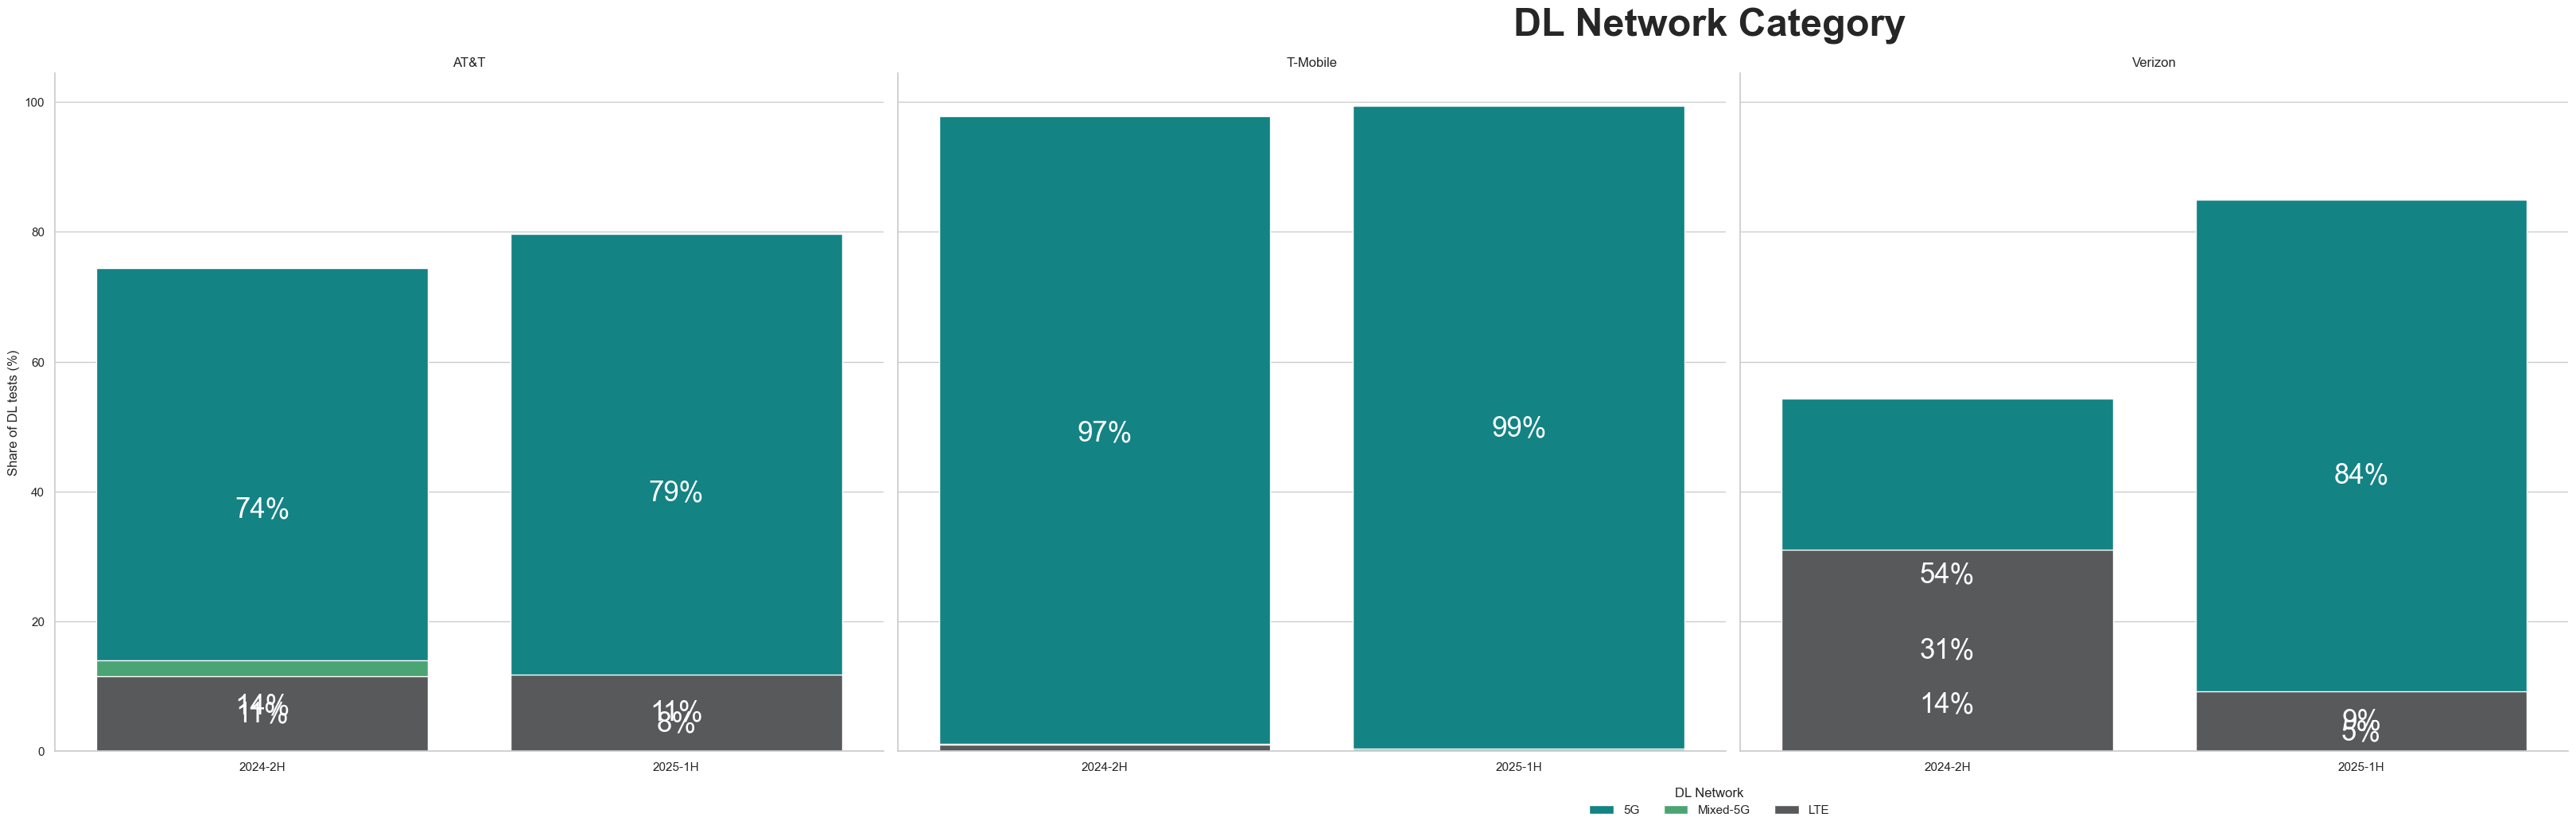

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2024-2H,AT&T,5G,519,74.36,47.0,363.7,1119.3,1372.1,99.8,99.9
1,2024-2H,AT&T,Mixed-5G,98,14.04,48.0,108.7,739.0,958.8,100.0,97.7
2,2024-2H,AT&T,LTE,81,11.60,48.0,27.6,184.1,377.5,98.9,94.5
3,2024-2H,T-Mobile,5G,686,97.86,40.0,428.4,1203.4,1422.0,99.9,99.8
4,2024-2H,T-Mobile,Mixed-5G,8,1.14,44.0,65.1,280.3,805.2,100.0,90.3
5,2024-2H,T-Mobile,LTE,7,1.00,86.0,2.2,20.3,27.3,95.2,98.4
6,2024-2H,Verizon,5G,381,54.35,54.0,206.2,568.4,824.0,100.0,99.8
7,2024-2H,Verizon,Mixed-5G,102,14.55,53.0,94.5,369.3,672.4,100.0,99.5
8,2024-2H,Verizon,LTE,218,31.10,55.0,43.1,212.3,339.5,100.0,100.0
9,2025-1H,AT&T,5G,591,79.65,42.0,361.1,1039.5,1226.4,100.0,99.8


In [2108]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Add a column to distinguish between current and comparison data

df_dl_5g_curr["product_period"] = df_dl_5g_curr["product_period"]
df_dl_5g_comp["product_period"] = df_dl_5g_comp["product_period"]

# Combine the two DataFrames
df_dl_5g_combined = pd.concat([df_dl_5g_comp,df_dl_5g_curr], ignore_index=True)

# Create FacetGrid
g = sns.FacetGrid(df_dl_5g_combined, col="carrier", col_wrap=4, height=10, sharey=True)

# Map bar plots
g.map_dataframe(sns.barplot, x="product_period", y="dl_pct", hue="dl_network",
                palette=dl_color_dict, dodge=False, errorbar=None)

# Add text labels to bars (only for current data)
for ax, (_, subdata) in zip(g.axes.flat, df_dl_5g_curr.groupby("carrier")):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height >= 3:
                ax.text(bar.get_x() + bar.get_width() / 2., height / 2,
                        f'{int(height)}%', ha='center', va='center', color='white', fontsize=25)

# Customize layout
g.set_axis_labels("", "Share of DL tests (%)")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("DL Network Category", fontsize=35, fontweight='bold')
g.add_legend(title="DL Network", bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=3)
plt.tight_layout()
plt.show()



df_dl_5g_combined.head(len(df_dl_5g_combined))

Current:

In [2109]:
network_category_curr = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{curr_csid} tea
  join prod_ms_partitions.test_summary_{curr_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') AND  ts.blacklisted = false and ts.flag_valid = true and ts.collection_set_period_id is not null and ts.test_type_id in (20,19,26)
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''

df_network_category_curr = pd.read_sql_query(network_category_curr, con=os.getenv('RSR_SVC_CONN'))
df_network_category_curr.head()

,product_period,carrier,network,count,percent
0,2025-1H,AT&T,5G,1311,59.1
1,2025-1H,AT&T,Mixed-5G,171,7.7
2,2025-1H,AT&T,LTE,738,33.2
3,2025-1H,T-Mobile,5G,2208,99.5
4,2025-1H,T-Mobile,Mixed-5G,8,0.4


Comparisson:

In [2110]:
network_category_comp = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{comp_csid} tea
  join prod_ms_partitions.test_summary_{comp_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') AND  ts.blacklisted = false and ts.flag_valid = true and ts.collection_set_period_id is not null and ts.test_type_id in (20,19,26)
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''
df_network_category_comp = pd.read_sql_query(network_category_comp, con=os.getenv('RSR_SVC_CONN'))
df_network_category_comp.head()

,product_period,carrier,network,count,percent
0,2024-2H,AT&T,5G,752,35.9
1,2024-2H,AT&T,Mixed-5G,207,9.9
2,2024-2H,AT&T,LTE,1138,54.3
3,2024-2H,T-Mobile,5G,2048,97.5
4,2024-2H,T-Mobile,Mixed-5G,35,1.7


Data Network Category filtered and reshape by network type

In [2111]:
# Combine the current and comparison DataFrames
df_network_category_combined = pd.concat([df_network_category_curr, df_network_category_comp], ignore_index=True)

# Reshape the DataFrame
df_network_category_reshaped = df_network_category_combined.pivot_table(
    index=["product_period", "carrier"], 
    columns="network", 
    values="percent"
).reset_index()

# Sort by 'carrier'
df_network_category_reshaped = df_network_category_reshaped.sort_values(by="carrier").reset_index(drop=True)

# Display the entire DataFrame
df_network_category_reshaped.head(len(df_network_category_reshaped))

network,product_period,carrier,5G,LTE,Mixed-5G
0,2024-2H,AT&T,35.9,54.3,9.9
1,2025-1H,AT&T,59.1,33.2,7.7
2,2024-2H,T-Mobile,97.5,0.9,1.7
3,2025-1H,T-Mobile,99.5,0.1,0.4
4,2024-2H,Verizon,37.2,47.4,15.4
5,2025-1H,Verizon,75.0,19.3,5.7


                                    Download Network Technology

In [2112]:
dl_lte_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date

dl_lte_comp = df_ts_comp [df_ts_comp ['test_type_id'] == 20]
dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


filtered_net_type_curr = (
    dl_lte_curr['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_curr['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"]))
   
filtered_net_type_comp = (
    dl_lte_comp['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_comp['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"])
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


                                            DL LTE market Daily

Current:

In [2113]:
lte_1 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_2 = (
    dl_lte_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_curr = pd.merge(lte_1, lte_2, on=['carrier', 'start_date'], how='left').fillna(0)

lte_curr['lte_pct'] = round((lte_curr['lte_count'] / lte_curr['total_tests']) * 100, 2)

# lte_curr.head()

Comparison:

In [2114]:

lte_3 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_4 = (
    dl_lte_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_comp = pd.merge(lte_3, lte_4, on=['carrier', 'start_date'], how='left').fillna(0)

lte_comp['lte_pct'] = round((lte_comp['lte_count'] / lte_comp['total_tests']) * 100, 2)

# lte_comp.head()

                                                DL LTE Overall

Current:

In [2115]:
lte_5 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_6 = (
    dl_lte_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_curr = pd.merge(lte_5, lte_6, on=['carrier'], how='left').fillna(0)

lte_all_curr['mean_LTE_curr'] = round((lte_all_curr['lte_count'] / lte_all_curr['total_tests']) * 100, 2)

# lte_all_curr.head()

Comparison:

In [2116]:
lte_7 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_8 = (
    dl_lte_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_comp = pd.merge(lte_7, lte_8, on=['carrier'], how='left').fillna(0)

lte_all_comp['mean_LTE_comp'] = round((lte_all_comp['lte_count'] / lte_all_comp['total_tests']) * 100, 2)

# lte_all_comp.head()

PLOT GRAPH

Compute the EOM table

                                                    M2M VoLTE/VoNR/EPS Fallback

In [2117]:
call_data_curr = df_ts_curr[df_ts_curr['test_type_id'] == 23]
call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date

call_data_comp = df_ts_comp[df_ts_comp['test_type_id'] == 23]
call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date


filtered_call_net_type_curr = (
    call_data_curr['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

filtered_call_net_type_comp = (
    call_data_comp['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1361281093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1361281093.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date


Current VoLTE:

In [2118]:
volte_1 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_curr = pd.merge(volte_1, volte_2, on=['carrier', 'start_date'], how='left').fillna(0)

volte_curr['volte_pct'] = round((volte_curr['volte_count'] / volte_curr['total_tests']) * 100, 2)

volte_curr.head()

,carrier,start_date,volte_count,total_tests,volte_pct
0,AT&T,2025-01-23,107,107,100.0
1,AT&T,2025-01-24,108,108,100.0
2,AT&T,2025-01-25,105,105,100.0
3,AT&T,2025-01-26,102,102,100.0
4,AT&T,2025-01-27,107,107,100.0


Comparison VoLTE:

In [2119]:
volte_3 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_comp = pd.merge(volte_1, volte_2, on=['carrier', 'start_date'], how='left').fillna(0)

volte_comp['volt_pct'] = round((volte_comp['volte_count'] / volte_comp['total_tests']) * 100, 2)

volte_comp.head()

,carrier,start_date,volte_count,total_tests,volt_pct
0,AT&T,2025-01-23,107,107,100.0
1,AT&T,2025-01-24,108,108,100.0
2,AT&T,2025-01-25,105,105,100.0
3,AT&T,2025-01-26,102,102,100.0
4,AT&T,2025-01-27,107,107,100.0


                                                    DL LTE Overall

Current:

In [2120]:
volte_5 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_curr = pd.merge(volte_5, volte_6, on=['carrier'], how='left').fillna(0)

volte_all_curr['mean_voLTE_curr'] = round((volte_all_curr['volte_count'] / lte_all_curr['total_tests']) * 100, 2)

volte_all_curr.head()

,carrier,volte_count,total_tests,mean_voLTE_curr
0,AT&T,640,640,86.25
1,T-Mobile,638,640,85.98
2,Verizon,638,640,85.98


Comparison:

In [2121]:
volte_7 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_comp = pd.merge(volte_5, volte_6, on=['carrier'], how='left').fillna(0)

volte_all_comp['mean_voLTE_comp'] = round((volte_all_comp['volte_count'] / lte_all_comp['total_tests']) * 100, 2)

volte_all_comp.head()

,carrier,volte_count,total_tests,mean_voLTE_comp
0,AT&T,640,640,91.69
1,T-Mobile,638,640,91.01
2,Verizon,638,640,91.01


Debuging call_data_curr and comp

In [2122]:
#Are the same object?
# print(call_data_comp is call_data_curr) 

# # Check the if the source is the same
# print("Source of call_data_curr:")
# print(call_data_curr.head())

# print("Source of call_data_comp:")
# print(call_data_comp.head())

# # Check if filtered data is the same
# print("Filtered call_data_curr:")
# print(call_data_curr[filtered_call_net_type_curr].head())

# print("Filtered call_data_comp:")
# print(call_data_comp[filtered_call_net_type_comp].head())

PLOT GRAPH

compute the EOM table

                                Mobile-to-Mobile Call Block

In [2123]:
call_data_curr['blocked_call'] = 0
mask =(call_data_curr['flag_access_success'] == "FALSE")
call_data_curr.loc[mask, 'blocked_call'] = 1

filtered_call_block_curr = (
    call_data_curr['blocked_call'] == 1
)

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == "FALSE")
call_data_comp.loc[mask, 'blocked_call'] = 1

filtered_call_block_comp = (
    call_data_comp['blocked_call'] == 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338245331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338245331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['blocked_call'] = 0


M2M Block Rate Current market Daily

In [2124]:
blk_1 = (
    call_data_curr[filtered_call_block_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_curr = pd.merge(blk_1, blk_2, on=['carrier', 'start_date'], how='right').fillna(0)

block_curr['block_pct'] = round((block_curr['block_count'] / block_curr['total_tests']) * 100, 2)

block_curr = block_curr[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

block_curr.head(len(block_curr))

,carrier,start_date,block_count,total_tests,block_pct
0,AT&T,2025-01-23,0.0,107,0.0
1,AT&T,2025-01-24,0.0,108,0.0
2,AT&T,2025-01-25,0.0,105,0.0
3,AT&T,2025-01-26,0.0,102,0.0
4,AT&T,2025-01-27,0.0,107,0.0
5,AT&T,2025-01-28,0.0,111,0.0
6,T-Mobile,2025-01-23,0.0,107,0.0
7,T-Mobile,2025-01-24,0.0,108,0.0
8,T-Mobile,2025-01-25,0.0,105,0.0
9,T-Mobile,2025-01-26,0.0,102,0.0


M2M Block Rate Comparison market Daily

In [2125]:
blk_3 = (
    call_data_comp[filtered_call_block_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_comp = pd.merge(blk_3, blk_4, on=['carrier', 'start_date'], how='right').fillna(0)

block_comp['block_pct'] = round((block_comp['block_count'] / block_comp['total_tests']) * 100, 2)

block_comp = block_comp[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

block_comp.head()

,carrier,start_date,block_count,total_tests,block_pct
0,AT&T,2024-07-23,0.0,90,0.0
1,AT&T,2024-07-24,0.0,110,0.0
2,AT&T,2024-07-25,0.0,106,0.0
3,AT&T,2024-07-26,0.0,109,0.0
4,AT&T,2024-07-27,0.0,104,0.0


                                                        M2M Block Rate Overall

Current:

In [2126]:
blk_5 = (
    call_data_curr[filtered_call_block_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_curr = pd.merge(blk_5, blk_6, on=['carrier'], how='right').fillna(0)

block_all_curr['block_rate_curr'] = round((block_curr['block_count'] / block_curr['total_tests']) * 100, 2)
# Reorder the columns
block_all_curr = block_all_curr[['carrier', 'block_count', 'total_tests', 'block_rate_curr']]
block_all_curr.head()

,carrier,block_count,total_tests,block_rate_curr
0,AT&T,0.0,640,0.0
1,T-Mobile,0.0,640,0.0
2,Verizon,0.0,640,0.0


Comparison:

In [2127]:
blk_7 = (
    call_data_comp[filtered_call_block_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_comp = pd.merge(blk_5, blk_6, on=['carrier'], how='right').fillna(0)

block_all_comp['block_rate_comp'] = round((block_comp['block_count'] / block_comp['total_tests']) * 100, 2)
# Reorder the columns
block_all_comp = block_all_comp[['carrier', 'block_count', 'total_tests', 'block_rate_comp']]

block_all_comp.head()

,carrier,block_count,total_tests,block_rate_comp
0,AT&T,0.0,640,0.0
1,T-Mobile,0.0,640,0.0
2,Verizon,0.0,640,0.0


                                                Mobile-to-Mobile Call Drop

In [2128]:
call_data_curr['blocked_call'] = 0





mask =(call_data_curr['flag_access_success'] == "FALSE")
call_data_curr.loc[mask, 'blocked_call'] = 1


call_data_curr['dropped_call'] = 0
mask = (call_data_curr['flag_task_success'] == "FALSE")
call_data_curr.loc[mask, 'dropped_call'] = 1

call_data_curr['incomplete_call'] = 0
mask = (call_data_curr['flag_access_success'] == "TRUE") & \
       (call_data_curr['flag_task_success'] == "NULL")
call_data_curr.loc[mask, 'incomplete_call'] = 1

# filter curr
filtered_call_drop_curr = (
    call_data_curr['dropped_call'] == 1
)

filtered_call_not_block_curr = (
    call_data_curr['blocked_call'] != 1
)

filtered_call_not_incomplete_curr = (
    call_data_curr['incomplete_call'] != 1
)

#comparison data

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == "FALSE")
call_data_comp.loc[mask, 'blocked_call'] = 1


call_data_comp['dropped_call'] = 0
mask = (call_data_comp['flag_task_success'] == "FALSE")
call_data_comp.loc[mask, 'dropped_call'] = 1

call_data_comp['incomplete_call'] = 0
mask = (call_data_comp['flag_access_success'] == "TRUE") & \
       (call_data_comp['flag_task_success'] == "NULL")
call_data_comp.loc[mask, 'incomplete_call'] = 1

# filter comp
filtered_call_drop_comp = (
    call_data_comp['dropped_call'] == 1
)

filtered_call_not_block_comp = (
    call_data_comp['blocked_call'] != 1
)

filtered_call_not_incomplete_comp = (
    call_data_comp['incomplete_call'] != 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4269420777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4269420777.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['dropped_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4269420777.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Current:

In [2129]:
drop_1 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_2 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_curr = pd.merge(drop_1, drop_2, on=['carrier', 'start_date'], how='right').fillna(0)

drop_curr['drop_pct'] = round((drop_curr['drop_count'] / drop_curr['total_tests']) * 100, 2)

drop_curr = drop_curr[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

drop_curr.head()

,carrier,start_date,drop_count,total_tests,drop_pct
0,AT&T,2025-01-23,0.0,107,0.0
1,AT&T,2025-01-24,0.0,108,0.0
2,AT&T,2025-01-25,0.0,105,0.0
3,AT&T,2025-01-26,0.0,102,0.0
4,AT&T,2025-01-27,0.0,107,0.0


Comparison:

In [2130]:
drop_3 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_4 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_comp = pd.merge(drop_1, drop_2, on=['carrier', 'start_date'], how='right').fillna(0)

drop_comp['drop_pct'] = round((drop_comp['drop_count'] / drop_comp['total_tests']) * 100, 2)

drop_comp = drop_comp[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

drop_comp.head()

,carrier,start_date,drop_count,total_tests,drop_pct
0,AT&T,2025-01-23,0.0,107,0.0
1,AT&T,2025-01-24,0.0,108,0.0
2,AT&T,2025-01-25,0.0,105,0.0
3,AT&T,2025-01-26,0.0,102,0.0
4,AT&T,2025-01-27,0.0,107,0.0


                                                        M2M drop Rate Comparison market Overall

Current:

In [2131]:
drop_5 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_6 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_curr = pd.merge(drop_5, drop_6, on=['carrier'], how='right').fillna(0)

drop_all_curr['drop_rate_curr'] = round((drop_all_curr['drop_count'] / drop_all_curr['total_tests']) * 100, 2)

# Reorder the columns
drop_all_curr = drop_all_curr[['carrier', 'drop_count', 'total_tests', 'drop_rate_curr']]

drop_all_curr.head()

,carrier,drop_count,total_tests,drop_rate_curr
0,AT&T,0.0,640,0.0
1,T-Mobile,0.0,640,0.0
2,Verizon,0.0,640,0.0


Comparison

In [2132]:
drop_7 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_8 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_comp = pd.merge(drop_5, drop_6, on=['carrier'], how='right').fillna(0)

drop_all_comp['drop_rate_comp'] = round((drop_all_comp['drop_count'] / drop_all_comp['total_tests']) * 100, 2)

# Reorder the columns
drop_all_comp = drop_all_comp[['carrier', 'drop_count', 'total_tests', 'drop_rate_comp']]

drop_all_comp.head()

,carrier,drop_count,total_tests,drop_rate_comp
0,AT&T,0.0,640,0.0
1,T-Mobile,0.0,640,0.0
2,Verizon,0.0,640,0.0


                                            Download Throughput

In [ ]:
##Current
# Filter rows
filtered_dl_tput_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000

##Comparison:
# Filter rows
filtered_dl_tput_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_comp['start_date'] = pd.to_datetime(filtered_dl_tput_comp['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_comp['download_mbps'] = filtered_dl_tput_comp['dsd_effective_download_test_speed'] / 1000

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1849161255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1849161255.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ip

Current:

In [ ]:
dl_tput_curr = (
    filtered_dl_tput_curr
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_curr'})
)

dl_tput_curr['median_dl_tput_curr'] = dl_tput_curr['median_dl_tput_curr'].round(2)

dl_tput_curr.head()

,carrier,start_date,median_dl_tput_curr
0,AT&T,2025-01-23,313.94
1,AT&T,2025-01-24,209.79
2,AT&T,2025-01-25,285.64
3,AT&T,2025-01-26,365.37
4,AT&T,2025-01-27,327.55


Comparison:

In [ ]:
dl_tput_comp = (
    filtered_dl_tput_comp
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_comp'})
)

dl_tput_comp['median_dl_tput_comp'] = dl_tput_comp['median_dl_tput_comp'].round(2)

dl_tput_comp.head()

,carrier,start_date,median_dl_tput_comp
0,AT&T,2024-07-23,320.98
1,AT&T,2024-07-24,294.89
2,AT&T,2024-07-25,266.68
3,AT&T,2024-07-26,305.57
4,AT&T,2024-07-27,266.93


Current:

In [ ]:
dl_tput_all_curr = (
    filtered_dl_tput_curr
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_curr_line'})
)

dl_tput_all_curr['dl_tput_curr_line'] = dl_tput_all_curr['dl_tput_curr_line'].round(2)

dl_tput_all_curr.head()

,carrier,dl_tput_curr_line
0,AT&T,297.63
1,T-Mobile,454.96
2,Verizon,197.50


Comparison:

In [ ]:
dl_tput_all_comp = (
    filtered_dl_tput_comp
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_comp_line'})
)

dl_tput_all_comp['dl_tput_comp_line'] = dl_tput_all_comp['dl_tput_comp_line'].round(2)

dl_tput_all_comp.head()

,carrier,dl_tput_comp_line
0,AT&T,296.04
1,T-Mobile,422.64
2,Verizon,119.54
